<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Imports" data-toc-modified-id="Imports-1">Imports</a></span></li><li><span><a href="#Define-parameters" data-toc-modified-id="Define-parameters-2">Define parameters</a></span></li><li><span><a href="#Collect-list-of-files-and-split-into-train-and-test-sets" data-toc-modified-id="Collect-list-of-files-and-split-into-train-and-test-sets-3">Collect list of files and split into train and test sets</a></span></li><li><span><a href="#Extract-feature-data" data-toc-modified-id="Extract-feature-data-4">Extract feature data</a></span></li><li><span><a href="#Hyperparameter-tuning-for-logistic-regression-and-random-forest-models" data-toc-modified-id="Hyperparameter-tuning-for-logistic-regression-and-random-forest-models-5">Hyperparameter tuning for logistic regression and random forest models</a></span></li><li><span><a href="#Model-selection" data-toc-modified-id="Model-selection-6">Model selection</a></span></li><li><span><a href="#Evaluating-the-final-model" data-toc-modified-id="Evaluating-the-final-model-7">Evaluating the final model</a></span></li><li><span><a href="#Evaluating-other-problem-definitions" data-toc-modified-id="Evaluating-other-problem-definitions-8">Evaluating other problem definitions</a></span></li></ul></div>

# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import datetime
import os.path
import random
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
import sklearn.metrics 
from sklearn import tree, ensemble
from sklearn.ensemble import RandomForestClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn import calibration
import utils.bookdroputils as bd
import sklearn.model_selection as model_selection
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler

# Define parameters

In [2]:
# Specify the dataset to use
data_set = 'paperbacks' # 'boardgames' or 'paperbacks'

# Find directory for that dataset
data_folder = os.path.join('data',data_set)

# Number of timepoints to search ahead for a price drop
future = 60
# Fraction of the price considered a 'drop'
# E.g., 0.1 for a 10% price drop
drop_frac = .1

# Collect list of files and split into train and test sets

In [3]:
# Collect list of all files
file_list = [f for f in os.listdir(data_folder) if os.path.isfile(os.path.join(data_folder, f))]
# Split list into train and test sets
# (the same way we did for EDA)
train, test = train_test_split(file_list, test_size=0.2, random_state=777)

# Extract feature data

In [4]:
def extract_feature_data(files, data_set, future, drop_frac, verbose=False):
    # Store features and labels
    X = []
    Y = []
    # Also store dollars spent and time waited for each strategy
    dollars_spent = []
    time_waited = []
    
    # Display messages when progress crosses this threshold
    progress_threshold = 0
    num_processed = 0
    
    # For each product
    for file_name in files:
        # Read file
        df = pd.read_csv(os.path.join('data', data_set, file_name))
        # Drop missing values
        df.dropna(inplace=True)
        # Convert prices to array
        prices = np.array(df['price'])

        # Sample data at 1-month intervals, starting at a random point in time
        for k in range(
                random.randint(0, 30) + 120 + 5, df.shape[0] - future - 30,
                60):

            # Extract price features
            features = bd.compute_features(prices[:k + 1], drop_frac)

            # Store the features
            X.append(features)

            # Store the class label
            if np.any(prices[(k + 1):(k + future + 1)] < (1 - drop_frac) *
                      prices[k]):
                Y.append(1)
            else:
                Y.append(0)

            # Extract the prices in the lookahead period
            future_prices = prices[(k + 1):(k + future + 1)]

            # Compute dollars spent and time waited for each strategy
            if Y[-1] == 1:
                idx_below = np.argwhere(future_prices < (1 - drop_frac) *
                                        prices[k])[0].astype(int)[0]
                bookdrop_price = future_prices[idx_below]
                bookdrop_wait = idx_below + 1
                tracker_price = future_prices[idx_below]
                tracker_wait = idx_below + 1
                perfect_price = future_prices[idx_below]
                perfect_wait = idx_below + 1

            else:
                bookdrop_price = prices[k + future]
                bookdrop_wait = future
                tracker_price = prices[k + future]
                tracker_wait = future
                perfect_price = prices[k]
                perfect_wait = 0

            # Store the dollars spent
            dollars_spent.append(
                np.array([
                    perfect_price, bookdrop_price, tracker_price, prices[k],
                    prices[k + future]
                ]))

            # Store the time waited
            time_waited.append(
                np.array([perfect_wait, bookdrop_wait, tracker_wait]))

        # Show progress
        if verbose:
            num_processed += 1
            if num_processed / len(files) > progress_threshold:
                print(str(round(progress_threshold * 100)) + '% done')
                progress_threshold += .2
            
    return np.array(X), np.array(Y), np.array(dollars_spent), np.array(time_waited)

In [5]:
# Set random seeds for reproducibility
random.seed(99)
np.random.seed(99)

# Collect data from train and test sets
X_train, Y_train, dollars_spent_train, time_waited_train = extract_feature_data(train, data_set, future, drop_frac)
X_test, Y_test, dollars_spent_test, time_waited_test = extract_feature_data(test, data_set, future, drop_frac)

# Hyperparameter tuning for logistic regression and random forest models

In [6]:
# Keep a copy of the training data before splitting off a secondary test set for model selection
X_train_full = np.copy(X_train)
Y_train_full = np.copy(Y_train)
dollars_spent_train_full = np.copy(dollars_spent_train)
time_waited_train_full = np.copy(time_waited_train)

In [7]:
# Split off the secondary test set for model selection
X_train, X_test2, Y_train, Y_test2, \
    dollars_spent_train, dollars_spent_test2, \
    time_waited_train, time_waited_test2 = \
    train_test_split(X_train, Y_train, \
                     dollars_spent_train, time_waited_train, test_size=0.2, random_state=888)

In [8]:
# Balance classes in training set for the logistic regression model
undersample = RandomUnderSampler(sampling_strategy='majority', random_state = 999)
X_train_balanced, Y_train_balanced = undersample.fit_resample(X_train, Y_train)
# Perform featues scaling for the logistic regression model
scaler = MinMaxScaler(feature_range = (0,1))
scaler.fit(X_train_balanced)
X_train_scaled = scaler.transform(X_train_balanced)
X_test2_scaled = scaler.transform(X_test2)

# Define the parameter space to search for each model
# adapted from https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74
# and https://towardsdatascience.com/logistic-regression-model-tuning-with-scikit-learn-part-1-425142e01af5

# Number of trees in random forest
n_estimators = [100, 200, 300]
# Number of features to consider at every split
max_features = ['sqrt']
# Maximum number of levels in tree
max_depth = [5, 10]
# Minimum number of samples required to split a node
min_samples_split = [2, 4, 8]
# Minimum number of samples required at each leaf node
min_samples_leaf = [2, 4, 8]
# Method of selecting samples for training each tree
bootstrap = [True]

# Create the grid
rf_params = {
    'n_estimators': n_estimators,
    'max_features': max_features,
    'max_depth': max_depth,
    'min_samples_split': min_samples_split,
    'min_samples_leaf': min_samples_leaf,
    'bootstrap': bootstrap
}

# Define the parameter space to search for the logistic regression classifier
lr_params = {
    'penalty': ['l1', 'l2', 'elasticnet'],
    'C': np.logspace(-4, 4, 20)
}

lr_grid = model_selection.GridSearchCV(LogisticRegression(), param_grid = lr_params, \
                                       cv = 4, verbose=True, n_jobs=-1, scoring='recall')
rf_grid = model_selection.GridSearchCV(BalancedRandomForestClassifier(), param_grid = rf_params, \
                                       cv = 4, verbose=True, n_jobs=-1, scoring='recall')

In [9]:
# Fit the logistic regression grid search models
lr_grid.fit(X_train_scaled, Y_train_balanced)

Fitting 4 folds for each of 60 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:    2.1s finished


GridSearchCV(cv=4, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': array([1.00000000e-04, 2.63665090e-04, 6.95192796e-04, 1.83298071e-03,
       4.83293024e-03, 1.27427499e-02, 3.35981829e-02, 8.85866790e-02,
       2.33572147e-01, 6.15848211e-01, 1.62377674e+00, 4.28133240e+00,
       1.12883789e+01, 2.97635144e+01, 7.84759970e+01, 2.06913808e+02,
       5.45559478e+02, 1.43844989e+03, 3.79269019e+03, 1.00000000e+04]),
                         'penalty': ['l1', 'l2', 'elasticnet']},
             scoring='recall', verbose=True)

In [10]:
# Fit the random forest grid search models
rf_grid.fit(X_train, Y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 4 folds for each of 54 candidates, totalling 216 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   52.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 216 out of 216 | elapsed:  5.2min finished


GridSearchCV(cv=4, estimator=BalancedRandomForestClassifier(), n_jobs=-1,
             param_grid={'bootstrap': [True], 'max_depth': [5, 10],
                         'max_features': ['sqrt'],
                         'min_samples_leaf': [2, 4, 8],
                         'min_samples_split': [2, 4, 8],
                         'n_estimators': [100, 200, 300]},
             scoring='recall', verbose=True)

In [11]:
# Get the best model of each class
best_lr = lr_grid.best_estimator_
best_rf = rf_grid.best_estimator_

# Model selection

In [12]:
# Define a function to evaluate the performance of a model on a test set
def evaluate_model(model, x_test, y_test, dollars_spent_test, time_waited_test, future):
    # Make predictions on test set
    y_pred = model.predict(x_test)
    # Calculate accuracy
    accuracy = 100 * sum(y_pred == y_test)/len(y_pred)
    
    # Compute errors for the confusion matrix
    TN = np.sum(np.bitwise_and(y_test == 0, y_pred == 0))
    FP = np.sum(np.bitwise_and(y_test == 0, y_pred == 1))
    FN = np.sum(np.bitwise_and(y_test == 1, y_pred == 0))
    TP = np.sum(np.bitwise_and(y_test == 1, y_pred == 1))
    
    # Calculate precision
    precision = TP / (TP + FP)
    # Calculate recall
    recall = TP / (TP + FN)
    
    # Compute spending for each strategy
    cost_perfect = np.sum(dollars_spent_test[:, 0])
    cost_bookdrop = np.sum(dollars_spent_test[y_pred == 0, 3]) + np.sum(
        dollars_spent_test[y_pred == 1, 1])
    cost_tracker = np.sum(dollars_spent_test[:, 2])
    cost_now = np.sum(dollars_spent_test[:, 3])
    cost_wait_only = np.sum(dollars_spent_test[:, 4])
    
    # Spending for each strategy
    cost_perfect = dollars_spent_test[:, 0]
    cost_bookdrop = dollars_spent_test[np.arange(len(dollars_spent_test)), [3 if y == 0 else 1 for y in y_pred]]
    cost_tracker = dollars_spent_test[:, 2]
    cost_now = dollars_spent_test[:, 3]
    cost_wait_only = dollars_spent_test[:, 4]
    
    cost_perfect = sum(cost_perfect)
    cost_bookdrop = sum(cost_bookdrop)
    cost_tracker = sum(cost_tracker)
    cost_now = sum(cost_now)
    cost_wait_only = sum(cost_wait_only)
    
    # Time waited for each strategy
    lag_perfect = time_waited_test[:, 0]
    lag_bookdrop = np.append(time_waited_test[y_pred == 1, 1],np.zeros((sum(y_pred==0),1)))
    lag_tracker = time_waited_test[:, 2]
    
    # Median cost savings for each strategy
    perfect_savings = 100 * (1 - np.median(cost_perfect / cost_now))
    bookdrop_savings = 100 * (1 - np.median(cost_bookdrop / cost_now))
    tracker_savings = 100 * (1 - np.median(cost_tracker / cost_now))
    wait_only_savings = 100 * (1 - np.median(cost_wait_only / cost_now))
      
    # Efficiency
    bookdrop_efficiency = bookdrop_savings / perfect_savings
    tracker_efficiency = tracker_savings / perfect_savings
    wait_only_efficiency = wait_only_savings / perfect_savings
    
    # Days waited
    perfect_days = np.mean(lag_perfect) / 2
    bookdrop_days = np.mean(lag_bookdrop) / 2
    tracker_days = np.mean(lag_tracker) / 2
    wait_only_days = future / 2
     
    # Time saved
    perfect_time_savings = 100 - 100 * (perfect_days / wait_only_days)
    bookdrop_time_savings = 100 - 100 * (bookdrop_days / wait_only_days)
    
    simulation_results = pd.DataFrame(
        [[perfect_savings, 1, perfect_days,perfect_time_savings],
         [bookdrop_savings, bookdrop_efficiency, bookdrop_days, bookdrop_time_savings],
         [tracker_savings,tracker_efficiency,tracker_days,''],
         [wait_only_savings,wait_only_efficiency,wait_only_days,'']
        ],
        columns=['median_savings', 'efficiency', 'mean_wait_time', 'time_saved'],
        index=['Perfect','BookDrop','Tracker only','Wait'])
    
    return accuracy, precision, recall, simulation_results, TP, FP, TN, FN

In [13]:
# Evaluate the best model of each class on the secondary test set
print('Logistic regression')
accuracy, precision, recall, simulation_results, TP, FP, TN, FN = \
    evaluate_model(best_lr, X_test2_scaled, Y_test2, dollars_spent_test2, time_waited_test2, future)
print('Accuracy: '+str(accuracy))
print('Precision: '+str(precision))
print('Recall: '+str(recall))
print(simulation_results)
print('')
print('Random forest')
accuracy, precision, recall, simulation_results, TP, FP, TN, FN = \
    evaluate_model(best_rf, X_test2, Y_test2, dollars_spent_test2, time_waited_test2, future)
print('Accuracy: '+str(accuracy))
print('Precision: '+str(precision))
print('Recall: '+str(recall))
print(simulation_results)

Logistic regression
Accuracy: 72.0310264327133
Precision: 0.28832292167227297
Recall: 0.6147540983606558
              median_savings  efficiency  mean_wait_time time_saved
Perfect             3.158397    1.000000        1.910573    93.6314
BookDrop            1.221924    0.386881        7.801755    73.9942
Tracker only        0.713358    0.225861       27.500602           
Wait               -0.113927   -0.036071       30.000000           

Random forest
Accuracy: 72.95730100158144
Precision: 0.3041816009557945
Recall: 0.6521516393442623
              median_savings  efficiency  mean_wait_time time_saved
Perfect             3.158397    1.000000        1.910573    93.6314
BookDrop            1.480773    0.468837        7.759282    74.1357
Tracker only        0.713358    0.225861       27.500602           
Wait               -0.113927   -0.036071       30.000000           


The random forest model has higher recall and efficiency, so I will use it even though the logistic regression model has better accuracy.

# Evaluating the final model

In [14]:
# Show parameters for the best random forest model
rf_grid.best_params_

{'bootstrap': True,
 'max_depth': 10,
 'max_features': 'sqrt',
 'min_samples_leaf': 4,
 'min_samples_split': 4,
 'n_estimators': 300}

In [15]:
# Train a model with the tuned parameters
RF_model = BalancedRandomForestClassifier(**rf_grid.best_params_)
RF_model.fit(X_train_full, Y_train_full)

BalancedRandomForestClassifier(max_depth=10, max_features='sqrt',
                               min_samples_leaf=4, min_samples_split=4,
                               n_estimators=300)

In [16]:
# Evaluate the final model on the actual test set
accuracy, precision, recall, simulation_results, TP, FP, TN, FN = \
    evaluate_model(RF_model, X_test, Y_test, dollars_spent_test, time_waited_test, future)
print('Accuracy: '+str(accuracy))
print('Precision: '+str(precision))
print('Recall: '+str(recall))
print(simulation_results)

Accuracy: 72.60106415509755
Precision: 0.3006939090208173
Recall: 0.6467661691542289
              median_savings  efficiency  mean_wait_time time_saved
Perfect             2.937577    1.000000        1.960920    93.4636
BookDrop            1.645654    0.560208        7.853434    73.8219
Tracker only        0.915978    0.311814       27.535502           
Wait               -0.029454   -0.010027       30.000000           


<Figure size 648x648 with 0 Axes>

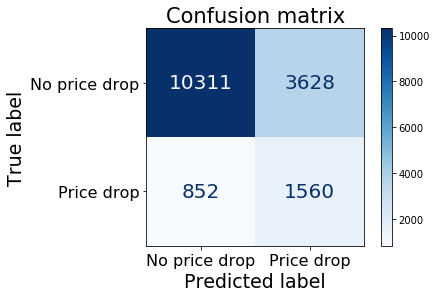

In [17]:
# Plot confusion matrix

# Generate the figure
fig = plt.figure(figsize=(9,9))
CM = sklearn.metrics.ConfusionMatrixDisplay(
    np.array([[TN, FP], [FN, TP]]),
    display_labels=['No price drop', 'Price drop']).plot(cmap=plt.cm.Blues,
                                                         values_format='d')
ax1 = CM.ax_
tx = CM.text_

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

ax1.set_title("Confusion matrix", fontsize=21)

ax1.set_ylabel(ylabel="True label", fontsize=19)
ax1.set_xlabel(xlabel="Predicted label", fontsize=19)

for i in [0, 1]:
    for j in [0, 1]:
        tx[i][j].set_fontsize(20)

# Evaluating other problem definitions

The positive class is defined as a price drop of 10% or more occurring over the next month, but there are other possible definitions. Below, I evaluate how useful each of those definitions might be.

In [18]:
# Set up the other definitions
futures = [28, 60, 120]
drop_fracs = [.05, .1, .2]

# Initialize evaluation metrics
savings = np.zeros((len(futures),len(drop_fracs)))
efficiency = np.zeros((len(futures),len(drop_fracs)))
time_saved = np.zeros((len(futures),len(drop_fracs)))

In [19]:
def evaluate_definition(future, drop_frac, train, test, data_set):
    # Extract the data
    X_train, Y_train, dollars_spent_train, time_waited_train = extract_feature_data(
        train, data_set, future, drop_frac)
    X_test, Y_test, dollars_spent_test, time_waited_test = extract_feature_data(
        test, data_set, future, drop_frac)
    # Train the model
    params = {
        'bootstrap': True,
        'max_depth': 5,
        'max_features': 'sqrt',
        'min_samples_leaf': 4,
        'min_samples_split': 2,
        'n_estimators': 100
    }
    RF_model = BalancedRandomForestClassifier(**params)
    RF_model.fit(X_train, Y_train)
    # Evaluate the model
    accuracy, precision, recall, simulation_results, TP, FP, TN, FN = \
        evaluate_model(RF_model, X_test, Y_test, dollars_spent_test, time_waited_test, future)
    return accuracy, precision, recall, simulation_results, TP, FP, TN, FN

In [20]:
# Evaluate each definition
for i in range(len(futures)):
    for j in range(len(drop_fracs)):
        accuracy, precision, recall, simulation_results, TP, FP, TN, FN = \
            evaluate_definition(futures[i], drop_fracs[i], train, test, data_set)
        
        savings[i,j] = simulation_results.loc['BookDrop','median_savings']
        efficiency[i,j] = simulation_results.loc['BookDrop','efficiency']
        time_saved[i,j] = simulation_results.loc['BookDrop','time_saved']

In [21]:
# Display metrics for each definition
labels = ['Savings', 'Efficiency', 'Time saved']
for idx, metric in enumerate([savings, efficiency, time_saved]):
    results = pd.DataFrame(metric, columns=drop_fracs, index=futures)
    print(labels[idx])
    print(results)

Savings
         0.05      0.10      0.20
28   0.824897  0.815777  0.917261
60   1.661280  1.655369  1.602021
120  2.226810  2.267235  2.292275
Efficiency
         0.05      0.10      0.20
28   0.423221  0.424644  0.462397
60   0.564605  0.565774  0.542472
120  0.703710  0.715196  0.721549
Time saved
          0.05       0.10       0.20
28   73.394125  72.140645  71.620560
60   73.909829  74.109405  73.902650
120  72.921655  72.282519  72.940939


Note that a 2-week lookahead period (28 12-hr periods) has low savings and efficiency, so those definitions are less useful. Then, because no drop fraction was more beneficial than any other, I decided to select 10% for the sake of simplicity. This means I will consider 10% drops for one- and two-month lookahead periods.